In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.ext.protodisk import ProtoPlanetaryDisk
from amuse.ext.composition_methods import *
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.lab import new_powerlaw_mass_distribution
from amuse.plot import scatter
from amuse.community.ph4.interface import ph4
from amuse.community.fi.interface import Fi
from amuse.couple import bridge
# from amuse.community.huayno.interface import Huayno

In [2]:
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

# def relative_orbital_velocity(distance, mass=SMBH.mass):
#     return (constants.G*mass/distance).sqrt()

def plot():
    plt.figure(figsize=(8,6))
    scatter(BHdisk.x.value_in(units.pc), BHdisk.y.value_in(units.pc), s=10, alpha=0.8, c='blue', label='BH')
    scatter(SMBH.x.value_in(units.pc), SMBH.y.value_in(units.pc), s=50, c='r', label='SMBH')
    plt.annotate(str(round(model_time.value_in(units.Myr)))+" Myr", xy=(6.9, 9), xytext=(6.9, 9), 
                 weight='heavy', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', ec='k', lw=1, alpha=0.5))
    #plt.title("Evolved to t = "+str(round(model_time.value_in(units.Myr)))+" Myr")
    plt.axis('square')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    

# Distance to (0,0)
def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

# Define collision detection
def merge_two_stars(bodies, particles_in_encounter):
    com_pos = particles_in_encounter.center_of_mass()
    com_vel = particles_in_encounter.center_of_mass_velocity()
    d = (particles_in_encounter[0].position - particles_in_encounter[1].position)
    v = (particles_in_encounter[0].velocity - particles_in_encounter[1].velocity)
    print("Two BHs", particles_in_encounter.name, particles_in_encounter.mass.in_(units.MSun),
          "collided with d=", d.length().in_(units.au))
    
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].mass = particles_in_encounter.total_mass()
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].position = com_pos
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].velocity = com_vel
    particles_in_encounter[np.argmax(particles_in_encounter.mass)].radius = particles_in_encounter.radius.sum()
    bodies.remove_particle(particles_in_encounter[np.argmin(particles_in_encounter.mass)])
    
#     new_particle=Particles(1)
#     new_particle.mass = particles_in_encounter.total_mass()
#     new_particle.name = particles_in_encounter[np.argmax(particles_in_encounter.mass)].name
#     new_particle.position = com_pos
#     new_particle.velocity = com_vel
#     new_particle.radius = particles_in_encounter.radius.sum()
#     bodies.add_particles(new_particle)
#     bodies.remove_particles(particles_in_encounter)
    
def resolve_collision(collision_detection, gravity, bodies):
    if collision_detection.is_set():
        print("Well, we have an actual collision between two or more BHs.")
        print("This happened at time=", gravity.model_time.in_(units.Myr))
        for ci in range(len(collision_detection.particles(0))): 
            encountering_particles = Particles(particles=[collision_detection.particles(0)[ci],
                                                          collision_detection.particles(1)[ci]])
            colliding_BHs = encountering_particles.get_intersecting_subset_in(bodies)
            merge_two_stars(bodies, colliding_BHs)
            bodies.synchronize_to(gravity.particles)

            
            
# Binaries detection
def get_binaries(particles,hardness=0.5,G=constants.G):
    n=len(particles)
    total_Ek=(0.5*particles.mass*(particles.vx**2+particles.vy**2+particles.vz**2)).sum()
    average_Ek=total_Ek/particles.mass.sum()
    max_mass=particles.mass.amax()
    limitE=hardness*average_Ek
    
    a=numpy.argsort(particles.x.number)
    a=np.delete(a,particles[a].name=="SMBH")
    n=len(a)

    binaries=[]

    for i in range(0, n-1):
        j=i+1
        while j<n and j<i+10 and (particles.x[a[j]]-particles.x[a[i]])<2*G*max_mass/limitE:
            r2=(particles.x[a[j]]-particles.x[a[i]])**2+ \
               (particles.y[a[j]]-particles.y[a[i]])**2+ \
               (particles.z[a[j]]-particles.z[a[i]])**2 
            v2=(particles.vx[a[j]]-particles.vx[a[i]])**2+ \
               (particles.vy[a[j]]-particles.vy[a[i]])**2+ \
               (particles.vz[a[j]]-particles.vz[a[i]])**2 
            r=r2**0.5
            eb=G*(particles.mass[a[i]]+particles.mass[a[j]])/r-0.5*v2
            if eb > limitE:
                binary=particles[[a[i],a[j]]].copy()
                binary.hardness=eb/average_Ek
                binaries.append(binary)
            j+=1  

    return binaries, average_Ek

## Initial condition

In [3]:
# Start with Sgr A*
SMBH = Particles(1) 
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms
SMBH.radius = 2*constants.G*SMBH.mass/constants.c**2

n_BHs = 300 # Number of stellar-mass BHs
r = 10 # (parsec) The outmost orbital radius of BHs surrounding the SMBH
model_time = 0 | units.Myr

# Make BH disk
def make_BHdisk_around_SMBH(SMBH, n_BHs=n_BHs):
    R = r|units.pc
    Ndisk = n_BHs
    Rin = 0.1
    Rout = 1
    Pinner1 = orbital_period(SMBH.mass, Rin*R)
    converter1 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    masses = new_powerlaw_mass_distribution(Ndisk, 1.0|units.MSun, 100.0|units.MSun, 2.35) # BH masses in powerlaw
    BHdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter1,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=masses.sum()/SMBH.mass).result
    BHdisk.mass = masses
    BHdisk.name = np.arange(1,n_BHs+1).astype("str")
    BHdisk.radius = 2*constants.G*BHdisk.mass/constants.c**2
    BHdisk.remove_attribute_from_store('u')
#     BHdisk.move_to_center()
    return BHdisk, Pinner1, converter1

# Make gas disk
def make_gasdisk_around_SMBH(SMBH):
    R = r|units.pc
    Ndisk = 1000
    Rin = 0.1
    Rout = 1
    Pinner2 = orbital_period(SMBH.mass, Rin*R)
    Mdisk = 1e-3 * SMBH.mass
    converter2 = nbody_system.nbody_to_si(SMBH.mass.sum(), R)
    
    gasdisk = ProtoPlanetaryDisk(Ndisk,
                              convert_nbody=converter2,
                              Rmin=Rin,
                              Rmax=Rout,
                              q_out=10.0,
                              discfraction=Mdisk/SMBH.mass).result
    gasdisk.name = "gas disk"
#     gasdisk.move_to_center()
    masses = Mdisk/float(Ndisk)
    gasdisk.mass = masses
    rho = 3.0 | (units.g/units.cm**3)
    gasdisk.radius = (gasdisk.mass/(4*rho))**(1./3.)
    return gasdisk, Pinner2, converter2

gasdisk, Pinner2, converter2 = make_gasdisk_around_SMBH(SMBH)
BHdisk, Pinner1, converter1 = make_BHdisk_around_SMBH(SMBH)

# Name each BH
for i in range(n_BHs):
    BHdisk[i].name = "BH"+BHdisk[i].name
    
# Backup
SMBH0, BHdisk0, gasdisk0 = SMBH.copy(), BHdisk.copy(), gasdisk.copy()

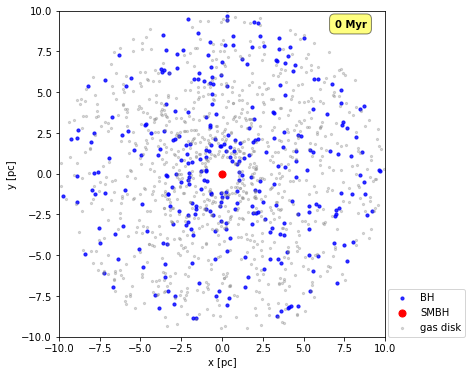

In [4]:
# The initial distribution of our objects
plot()
scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
plt.xlabel("x [pc]")
plt.ylabel("y [pc]")
plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
plt.show()

## Nbody simulation

In [5]:
gravity = ph4(converter1, number_of_workers=32)
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)
SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

gravity.particles.add_particles(bodies)
channel = gravity.particles.new_channel_to(bodies)

fig_root = "figure/Nbody/"

Evolved to t = 0 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH205' 'BH133'] with hardness = 0.632921453989 d = 17903.091357 au radius = 5.56752935333 parsec
Binary 2 is ['BH158' 'BH7'] with hardness = 1.16201313625 d = 9050.46605318 au radius = 3.52651216943 parsec
Binary 3 is ['BH282' 'BH220'] with hardness = 1.19140225983 d = 7523.34083859 au radius = 1.38936772649 parsec
Binary 4 is ['BH224' 'BH9'] with hardness = 0.882569087706 d = 9319.80368478 au radius = 1.70583820908 parsec


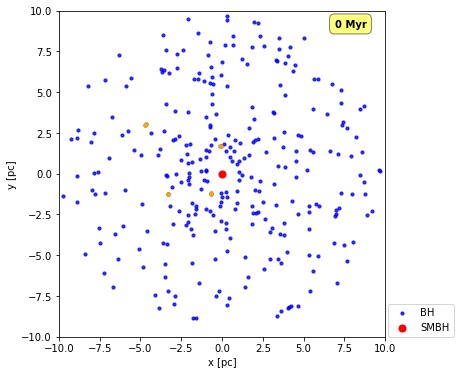



Evolved to t = 1 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH41' 'BH251'] with hardness = 0.638136267729 d = 6883.18636876 au radius = 1.92191137184 parsec
Binary 2 is ['BH158' 'BH7'] with hardness = 1.17153900192 d = 7984.35175961 au radius = 3.50008396492 parsec
Binary 3 is ['BH205' 'BH133'] with hardness = 0.603247407111 d = 18136.932702 au radius = 5.43396796106 parsec


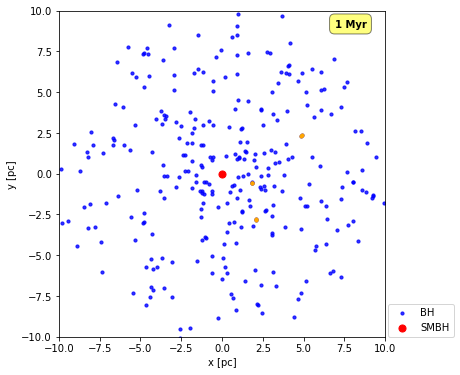



Evolved to t = 2 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH133' 'BH205'] with hardness = 0.816194848096 d = 9924.86290483 au radius = 4.85492560525 parsec


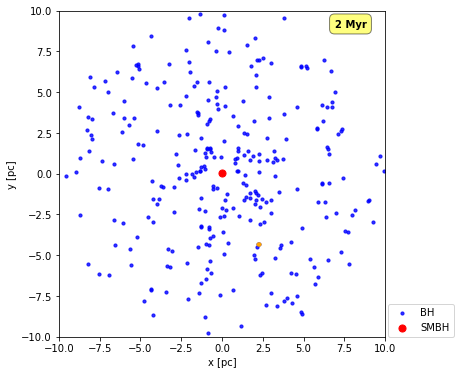



Evolved to t = 3 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH133' 'BH205'] with hardness = 0.825972556123 d = 10162.2002791 au radius = 4.96327347286 parsec


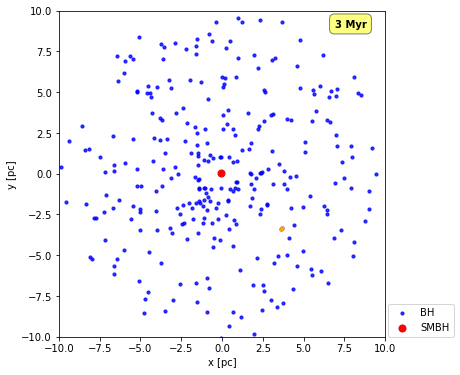



Evolved to t = 4 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH133' 'BH205'] with hardness = 0.804713491206 d = 5465.56699938 au radius = 4.87949976235 parsec


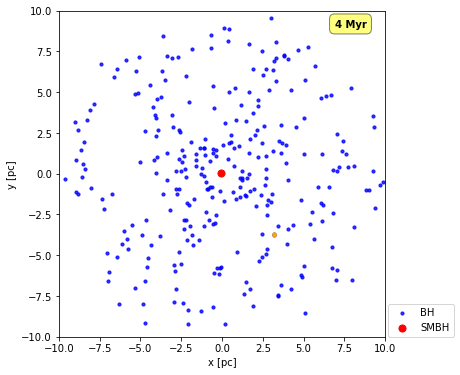



Evolved to t = 5 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH133' 'BH205'] with hardness = 0.845255919328 d = 11349.9342089 au radius = 4.71173837484 parsec


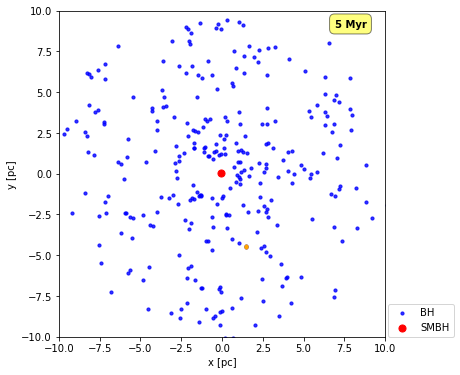



Evolved to t = 6 Myr 
BH number = 300
2 Binary found
Binary 1 is ['BH299' 'BH251'] with hardness = 0.810127864802 d = 12194.1713106 au radius = 1.7658390231 parsec
Binary 2 is ['BH133' 'BH205'] with hardness = 1.05225748045 d = 7659.51676601 au radius = 4.76101442787 parsec


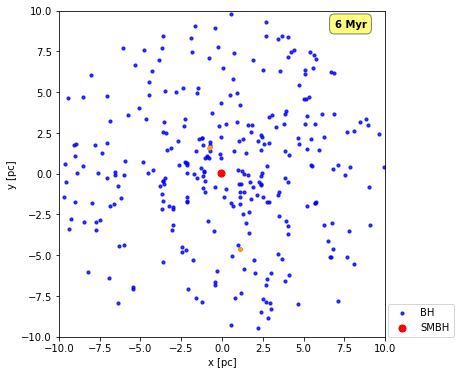



Evolved to t = 7 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH205' 'BH133'] with hardness = 1.050151785 d = 4631.529282 au radius = 4.66963037084 parsec


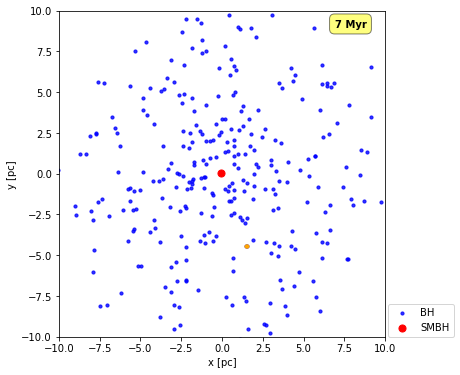



Evolved to t = 8 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH205' 'BH133'] with hardness = 1.06057968818 d = 10882.0787648 au radius = 4.54864149786 parsec


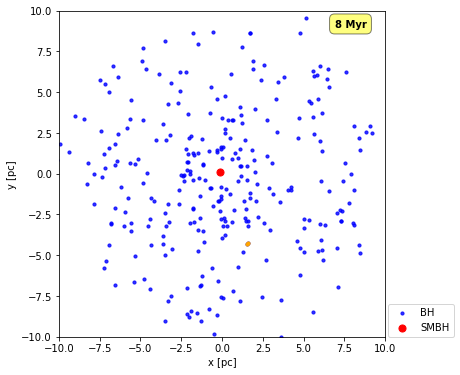



Evolved to t = 9 Myr 
BH number = 300
1 Binary found
Binary 1 is ['BH205' 'BH133'] with hardness = 1.04686639861 d = 6689.45063684 au radius = 4.75447889953 parsec


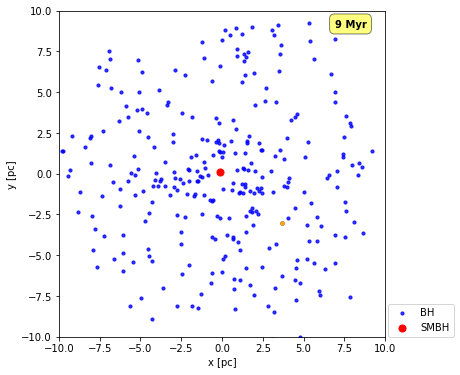

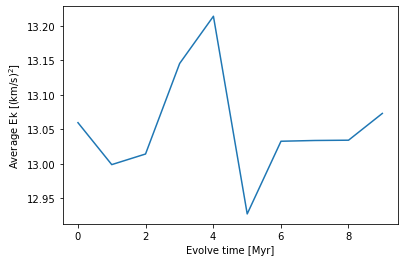

In [6]:
# Stopping condition of collision 
stopping_condition = gravity.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

bodies.radius *= collision_radius_multiplication_factor

# Evolving parameters
end_time = 10 | units.Myr
model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

evolve_time_list = [] | units.Myr 
average_Ek_list = [] | units.kms**2

bodies_x = []
bodies_y = []

# Evolve
while(model_time<end_time):
    
    gravity.evolve_model(model_time)
    resolve_collision(stopping_condition, gravity, bodies) # Collisions detection
    channel.copy()
    
    bodies_x.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    bodies_y.append(bodies.y.value_in(units.pc))
    
    if model_time.value_in(units.Myr)>=x:
        x += 1

        print("Evolved to t =", int(model_time.number), "Myr",
              "\nBH number =", len(BHdisk))

        plot()

        b, average_Ek = get_binaries(bodies) # Binaries detection
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
                      "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
                     "radius =", b[i].center_of_mass().length().in_(units.pc))
                
                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                               [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                               s=10, alpha=1, c='g')  

        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\n")

        evolve_time_list.append(model_time)
        average_Ek_list.append(average_Ek)
        
        
    model_time += dt
    

gravity.stop()

plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Bridge Nbody with gas disk

In [7]:
bodies = Particles(0)
bodies.add_particles(SMBH0)
bodies.add_particles(BHdisk0)

SMBH = bodies[bodies.name=="SMBH"]
BHdisk = bodies[bodies.name!="SMBH"]

Nbody = SMBH+BHdisk

gravityA = ph4(converter2, number_of_workers=32)
gravityA.particles.add_particles(Nbody)
channel = {"from_BHs": bodies.new_channel_to(gravityA.particles),
            "to_BHs": gravityA.particles.new_channel_to(bodies)}

hydro = Fi(converter2, mode="openmp", workers=32)
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 5e2 | units.yr
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False    # h_smooth is constant
eps = 10 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

bodies.add_particles(gasdisk0)
gasdisk = bodies[bodies.name=="gas disk"]

hydro.particles.add_particles(gasdisk)
# hydro.dm_particles.add_particles(SMBH.as_set())
channel.update({"from_gasdisk": gasdisk.new_channel_to(hydro.particles)})
channel.update({"to_gasdisk": hydro.particles.new_channel_to(gasdisk)})
# channel.update({"from_smbh": SMBH.new_channel_to(hydro.dm_particles)})
# channel.update({"to_smbh": hydro.dm_particles.new_channel_to(SMBH)})

fig_root = "figure/Bridge/"

In [8]:
# Bridge gravity and hydro
gravhydro = bridge.Bridge(use_threading=False) #, method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravityA, (hydro,))
gravhydro.add_system(hydro, (gravityA,))

# Stopping condition of collision 
stopping_condition = gravityA.stopping_conditions.collision_detection
stopping_condition.enable()
collision_radius_multiplication_factor = 1e5

Nbody.radius *= collision_radius_multiplication_factor

# Bridge timestep
gravhydro.timestep = 5e3 | units.yr

Evolved to t = 0 Myr 
BH number = 300
4 Binary found
Binary 1 is ['BH205' 'BH133'] with hardness = 0.632921453989 d = 17903.091357 au radius = 5.56752935333 parsec
Binary 2 is ['BH158' 'BH7'] with hardness = 1.16201313625 d = 9050.46605318 au radius = 3.52651216943 parsec
Binary 3 is ['BH282' 'BH220'] with hardness = 1.19140225983 d = 7523.34083859 au radius = 1.38936772649 parsec
Binary 4 is ['BH224' 'BH9'] with hardness = 0.882569087706 d = 9319.80368478 au radius = 1.70583820908 parsec


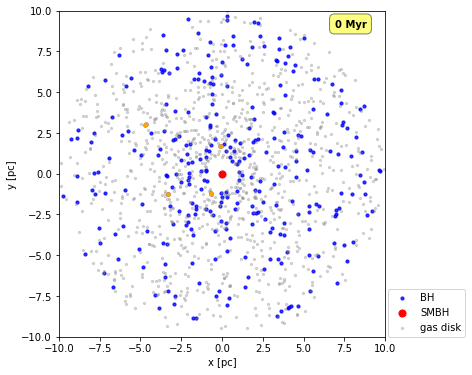



Evolved to t = 1 Myr 
BH number = 300
3 Binary found
Binary 1 is ['BH267' 'BH158'] with hardness = 0.550081254729 d = 8298.97549971 au radius = 3.45072062542 parsec
Binary 2 is ['BH158' 'BH7'] with hardness = 0.69886857711 d = 14821.5074662 au radius = 3.46451176427 parsec
Binary 3 is ['BH205' 'BH133'] with hardness = 0.632807139534 d = 17657.5846568 au radius = 5.42531730635 parsec


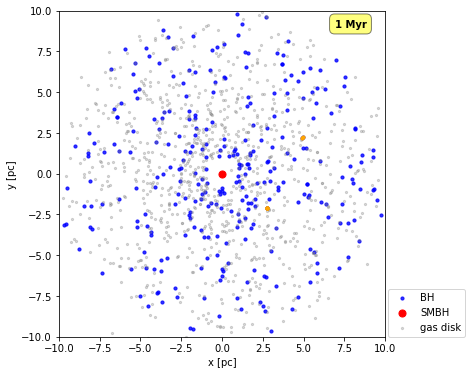



Evolved to t = 2 Myr 
BH number = 300


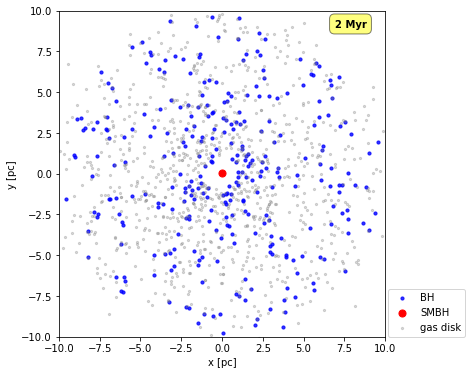



Evolved to t = 3 Myr 
BH number = 300


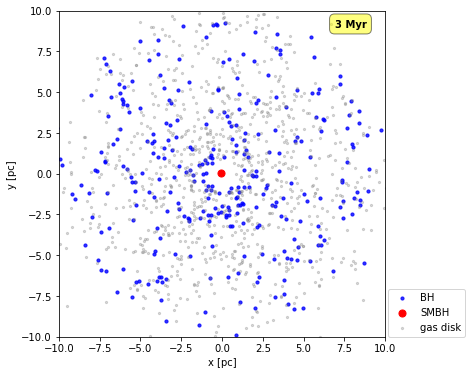



Evolved to t = 4 Myr 
BH number = 300


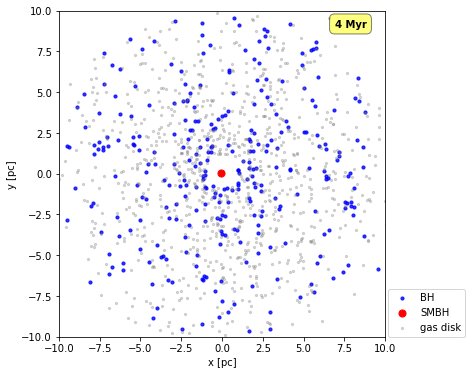



Evolved to t = 5 Myr 
BH number = 300


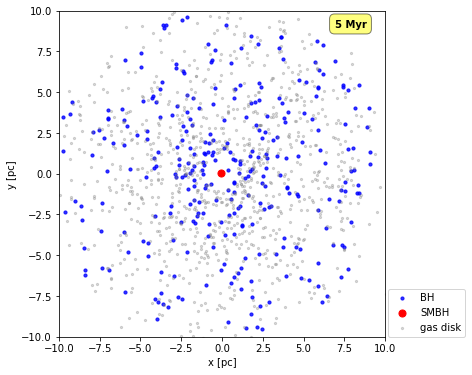



Evolved to t = 6 Myr 
BH number = 300


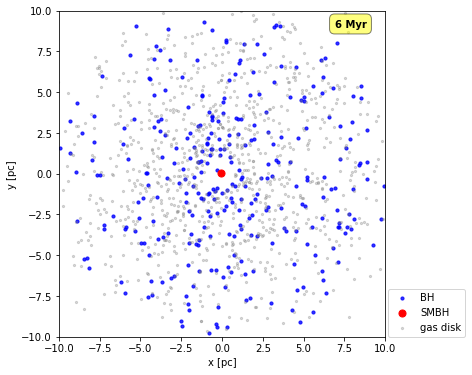



Evolved to t = 7 Myr 
BH number = 300


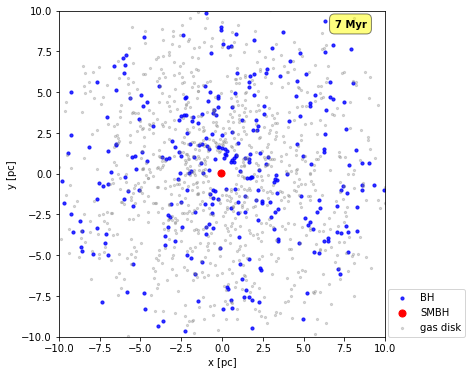



Evolved to t = 8 Myr 
BH number = 300


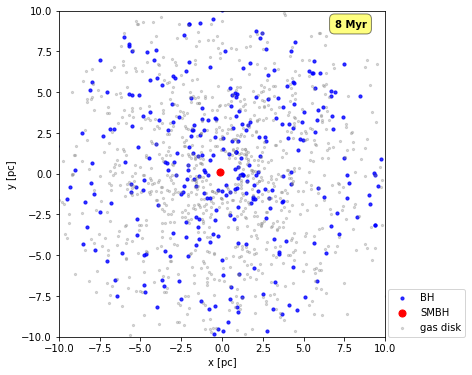



Evolved to t = 9 Myr 
BH number = 300


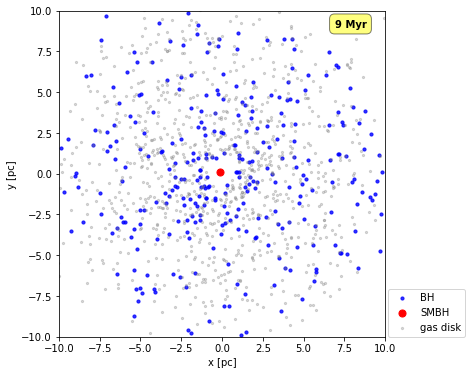

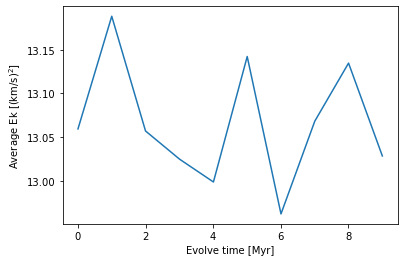

In [9]:
evolve_time_list_b = [] | units.Myr 
average_Ek_list_b = [] | units.kms**2

bodies_x_b = []
bodies_y_b = []

model_time = 0 | units.Myr
time = [] | units.Myr
dt = 1e-2 | units.Myr
x = 0

# def gravity_hydro_bridge(gravityA, hydro, gravhydro, bodies, end_time):
        
gravity_initial_total_energy = gravityA.get_total_energy() + hydro.get_total_energy()

while model_time < end_time:    

    gravhydro.evolve_model(model_time)
    resolve_collision(stopping_condition, gravityA, Nbody) # Collision detection
        
    channel["to_BHs"].copy()
    channel["to_gasdisk"].copy()
        
    bodies_x_b.append(bodies.x.value_in(units.pc)) # Restore positions for animation
    bodies_y_b.append(bodies.y.value_in(units.pc))

    if model_time.value_in(units.Myr)>=x:
        x+=1
        print("Evolved to t =", int(model_time.number), "Myr",
                "\nBH number =", len(BHdisk))
            
        plot()
        scatter(gasdisk.x.value_in(units.pc), gasdisk.y.value_in(units.pc), s=5, alpha=0.3, c='gray', label="gas disk")
            
        b, average_Ek = get_binaries(Nbody) # Binaries detection
        
        if(len(b)>0):
            print(len(b), "Binary found")
            
            for i in range(len(b)):
                print("Binary", i+1, "is", b[i].name, "with hardness =", b[i].hardness[0], 
                      "d =", (b[i].position[0] - b[i].position[1]).length().in_(units.au),
                     "radius =", b[i].center_of_mass().length().in_(units.pc))
                
                if b[i].hardness[0]<10:
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='orange')
                else:
                    print("Here we have a hard binary!!!")
                    scatter([b[i].x[0].value_in(units.pc), b[i].x[1].value_in(units.pc)], 
                                [b[i].y[0].value_in(units.pc), b[i].y[1].value_in(units.pc)], 
                                s=10, alpha=1, c='g') 
                        
        plt.xlabel("x [pc]")
        plt.ylabel("y [pc]")
        plt.legend(bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0)
        plt.savefig(fig_root+''+str(int(model_time.value_in(units.Myr)))+'_Myr.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\n")
            
        evolve_time_list_b.append(model_time)
        average_Ek_list_b.append(average_Ek)
        
    model_time += dt
        


gravityA.stop()
hydro.stop()

# end_time = 10 | units.Myr
# gravity_hydro_bridge(gravityA, hydro, gravhydro, 
#                      bodies, end_time)

plt.figure()
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2))
plt.xlabel('Evolve time [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.savefig(fig_root+'average_Ek.png')
plt.show()

## Animation 

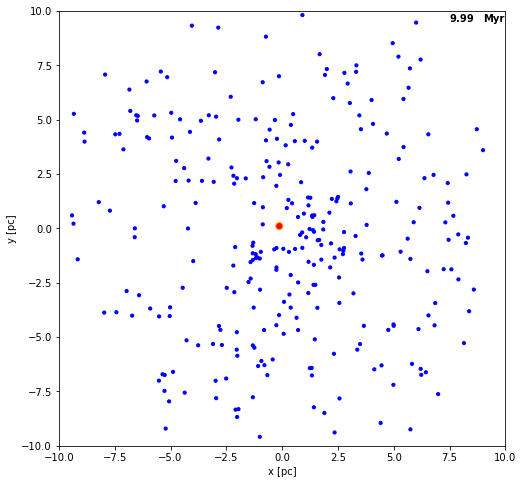

In [12]:
# Animation for Nbody
import os
import matplotlib.animation as animation
from amuse.io import read_set_from_file

def animate(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    
    for i in range(1, len(x[0])):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Nbody/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate(bodies_x, bodies_y)

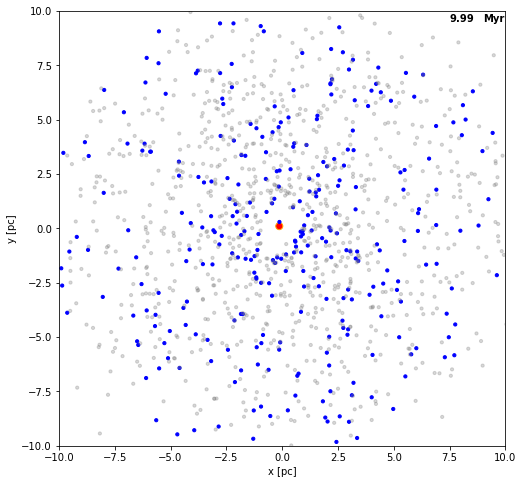

In [13]:
# Animation for bridge
def animate_b(x, y):

    def update(i):
        while i >= n: i -= n
        off = []
        for j in range(len(x[i])):
            off.append([x[i][j],y[i][j]])
#             off.append(y[i][j])
#         off = np.array(off)
        scat.set_offsets(off)
        time.set_text(round(i*dt.value_in(units.Myr),2))
        return scat, time
    
    n = len(x)
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    
    colormap = ['red']
    size = [50]
    edgecolor = ['orange']
    Alpha = [1]
    
    for i in range(1, len(BHdisk)+1):
        colormap.append('blue')
        size.append(10)
        edgecolor.append('blue')
        Alpha.append(1)
    for i in range(len(BHdisk)+1, len(bodies)):
        colormap.append('gray')
        size.append(10)
        edgecolor.append('gray')
        Alpha.append(0.3)
        
    time = ax.annotate(0, xy=(7.5, 9.5), xytext=(7.5, 9.5), weight='heavy')
    scat = ax.scatter(x[0], y[0], c=colormap, s=size, edgecolor=edgecolor, alpha=Alpha)
    anim = animation.FuncAnimation(fig, update, frames=1000, interval=50)
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    ax.annotate("Myr", xy=(9, 9.5), xytext=(9, 9.5), weight='heavy')
    anim.save('figure/Bridge/animation.gif',writer='imagemagick',dpi=100,fps=30);

animate_b(bodies_x_b, bodies_y_b)

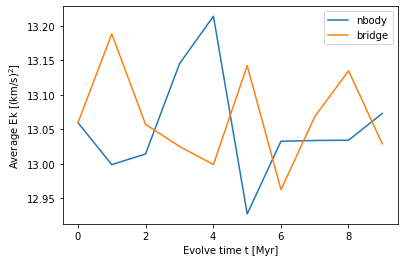

In [14]:
# Compare average kinetic energy
plt.figure()
plt.plot(evolve_time_list.value_in(units.Myr), average_Ek_list.value_in(units.kms**2), label="nbody")
plt.plot(evolve_time_list_b.value_in(units.Myr), average_Ek_list_b.value_in(units.kms**2), label="bridge")
plt.xlabel('Evolve time t [Myr]')
plt.ylabel('Average Ek [(km/s)$^2$]')
plt.legend(loc='best')
plt.savefig('figure/average_Ek of Nbody and Bridge simulation.png')
plt.show()